In [2]:
import pandas as pd
import numpy as np
import abc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def binary_split_by_class(X,y):
    x0=np.array([x for x,y in zip(X,y) if y==0])
    x1=np.array([x for x,y in zip(X,y) if y==1])
    return x0,x1

In [4]:
def split_train_test(X,y,train_ratio=0.8):
    n=len(X)
    n_train=int(n*train_ratio)
    indices=np.random.permutation(n)
    train_indices=indices[:n_train]
    test_indices=indices[n_train:]
    X_train=X[train_indices]
    y_train=y[train_indices]
    X_test=X[test_indices]
    y_test=y[test_indices]
    return X_train, y_train, X_test, y_test

In [5]:
class Model(abc.ABC):
    @abc.abstractmethod
    def fit(self, X, y):
        pass

    @abc.abstractmethod
    def predict(self, X):
        pass

    @abc.abstractmethod
    def predict_proba(self, X):
        pass
    
    @abc.abstractmethod
    def get_params(self):
        pass


In [6]:
class NB(Model):
    
    def __init__(self):
        self.means=None
        self.variances=None
        self.priors=None
    
    def fit(self, X, y):
        x0,x1=binary_split_by_class(X,y)
        self.means=np.ndarray((2,X.shape[1]))
        self.variances=np.ndarray((2,X.shape[1]))
        self.means[0]=x0.mean(axis=0)
        self.means[1]=x1.mean(axis=0)
        self.variances[0]=x0.var(axis=0)
        self.variances[1]=x1.var(axis=0)
        self.priors=np.ndarray((2,1))
        self.priors[0]=len(x0)/len(X)
        self.priors[1]=len(x1)/len(X)
        
    def calc_proba(self,X,p):
         p0=1
         p1=1
         for j in range(p):
             p0*=np.exp(-0.5*(X[j]-self.means[0,j])**2/self.variances[0,j])/np.sqrt(2*np.pi*self.variances[0,j])
             p1*=np.exp(-0.5*(X[j]-self.means[1,j])**2/self.variances[1,j])/np.sqrt(2*np.pi*self.variances[1,j])
         p0*=self.priors[0]
         p1*=self.priors[1]
         return p0,p1
    
    def predict(self, Xtest):
        y_pred=np.ndarray((Xtest.shape[0],1))
        for i in range(Xtest.shape[0]):
           p0,p1=self.calc_proba(Xtest[i],Xtest.shape[1])
           y_pred[i]=0 if p0>p1 else 1
        return y_pred
    
    def predict_proba(self, Xtest):
        y_proba=np.ndarray((Xtest.shape[0],1))
        for i in range(Xtest.shape[0]):
            p0,p1=self.calc_proba(Xtest[i],Xtest.shape[1])
            y_proba[i]=p1/(p0+p1)
        return y_proba
    
    def get_params(self):
        return self.means, self.variances, self.priors

In [7]:
class LDA(Model):
    
    def __init__(self):
        self.means=None
        self.W=None
        self.priors=None
    
    def __calc_S(self, X,mu):
        mu=mu.reshape((X.shape[1],1))
        S=np.zeros((X.shape[1],X.shape[1]))
        for j in range(X.shape[0]):
            xj=X[j].reshape((X.shape[1],1))
            S+=np.dot(xj-mu,xj.T-mu.T)
        return S/(X.shape[0]-1)
    
    def fit(self, X, y):
        x0,x1=binary_split_by_class(X,y)
        n0,n1=x0.shape[0],x1.shape[0]
        self.means=np.ndarray((2,X.shape[1]))
        self.means[0]=x0.mean(axis=0)
        self.means[1]=x1.mean(axis=0)
        S=np.ndarray((2,X.shape[1],X.shape[1]))
        S[0]=self.__calc_S(x0,self.means[0])
        S[1]=self.__calc_S(x1,self.means[1])
        self.W=((n0-1)*S[0]+(n1-1)*S[1])/(n0+n1-2)
        self.priors=np.ndarray((2,1))
        self.priors[0]=len(x0)/len(X)
        self.priors[1]=len(x1)/len(X)
        
    def calc_delta(self,x):
        mu0=self.means[0].reshape((x.shape[0],1))
        mu1=self.means[1].reshape((x.shape[0],1))
        W_inv=np.linalg.inv(self.W)
        prior_const=np.log(self.priors[0]/self.priors[1])
        return (mu0-mu1).T@W_inv@x-0.5*(mu0-mu1).T@W_inv@(mu0+mu1)+prior_const
    
    def predict(self, Xtest):
        y_pred=np.ndarray((Xtest.shape[0],1))
        for i in range(Xtest.shape[0]):
            x=Xtest[i].reshape((Xtest.shape[1],1))
            delta=self.calc_delta(x)
            y_pred[i]=0 if delta>0 else 1
        return y_pred
    
    def predict_proba(self, Xtest):
        y_proba=np.ndarray((Xtest.shape[0],1))
        for i in range(Xtest.shape[0]):
            x=Xtest[i].reshape((Xtest.shape[1],1))
            delta=self.calc_delta(x)
            y_proba[i]=1/(1+np.exp(delta))
        return y_proba
    
    def get_params(self):
        return self.means, self.W, self.priors

In [8]:
class QDA(Model):
    def __init__(self):
        self.means=None
        self.S=None
        self.priors=None
        
    def __calc_S(self, X,mu):
        mu=mu.reshape((X.shape[1],1))
        S=np.zeros((X.shape[1],X.shape[1]))
        for j in range(X.shape[0]):
            xj=X[j].reshape((X.shape[1],1))
            S+=np.dot(xj-mu,xj.T-mu.T)
        return S/(X.shape[0]-1)
    
    def fit(self, X, y):
        x0,x1=binary_split_by_class(X,y)
        self.means=np.ndarray((2,X.shape[1]))
        self.means[0]=x0.mean(axis=0)
        self.means[1]=x1.mean(axis=0)
        self.S=np.ndarray((2,X.shape[1],X.shape[1]))
        self.S[0]=self.__calc_S(x0,self.means[0])
        self.S[1]=self.__calc_S(x1,self.means[1])
        self.priors=np.ndarray((2,1))
        self.priors[0]=len(x0)/len(X)
        self.priors[1]=len(x1)/len(X)
        
    def __calc_deltas(self,x):
        mu0=self.means[0].reshape((x.shape[0],1))
        mu1=self.means[1].reshape((x.shape[0],1))
        delta_0=-0.5*np.linalg.det(self.S[0])-0.5*(x-mu0).T@np.linalg.inv(self.S[0])@(x-mu0)+np.log(self.priors[0])
        delta_1=-0.5*np.linalg.det(self.S[1])-0.5*(x-mu1).T@np.linalg.inv(self.S[1])@(x-mu1)+np.log(self.priors[1])
        return delta_0,delta_1
    
    def predict_proba(self, Xtest):
        y_proba=np.ndarray((Xtest.shape[0],1))
        for i in range(Xtest.shape[0]):
            x=Xtest[i].reshape((Xtest.shape[1],1))
            delta0,delta1=self.__calc_deltas(x)
            y_proba[i]=1/(1+np.exp(delta0-delta1))
        return y_proba
    
    def get_params(self):
        return self.means, self.S, self.priors
    
    def predict(self, Xtest):
        y_pred=np.ndarray((Xtest.shape[0],1))
        for i in range(Xtest.shape[0]):
            x=Xtest[i].reshape((Xtest.shape[1],1))
            delta0,delta1=self.__calc_deltas(x)
            y_pred[i]=0 if delta0>delta1 else 1
        return y_pred

In [9]:
def prepare_data_scheme_one(alfa,n,p=2):
    y = np.random.binomial(1,0.5,n)
    y.resize((n,1))
    X = np.ndarray((n,p))
    for i in range(n):
        if y[i]==0:
            X[i]=np.random.normal(0,1,p)
        else:
            X[i]=np.random.normal(alfa,1,p)
    return X, y

In [10]:
def prepare_data_scheme_two(alfa,rho,n,p=2):
    y = np.random.binomial(1,0.5,n)
    y.resize((n,1))
    X = np.ndarray((n,p))
    for i in range(n):
        if y[i]==0:
            X[i]=np.random.multivariate_normal([0,0],[[1,rho],[rho,1]])
        else:
            X[i]=np.random.multivariate_normal([alfa,alfa],[[1,-rho],[-rho,1]])
    return X, y

In [11]:
def comparison_one():
    alpha=[0.1,0.5,1,2,3,5]
    splits=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
    rho=0.5
    fig,axes=plt.subplots(2,3,figsize=(15,15))
    nb_df=pd.DataFrame(columns=['alpha','accuracy'])
    lda_df=pd.DataFrame(columns=['alpha','accuracy'])
    qda_df=pd.DataFrame(columns=['alpha','accuracy'])
    nb_df2=pd.DataFrame(columns=['alpha','accuracy'])
    lda_df2=pd.DataFrame(columns=['alpha','accuracy'])
    qda_df2=pd.DataFrame(columns=['alpha','accuracy'])
    for a in alpha:
        X,y=prepare_data_scheme_one(a,1000)
        X_2,y_2=prepare_data_scheme_two(a,rho,1000)
        for split in splits:
            X_train, y_train, X_test, y_test=split_train_test(X,y,split)
            X_2_train, y_2_train, X_2_test, y_2_test=split_train_test(X_2,y_2,split)
            nb=NB()
            nb2=NB()
            
            nb.fit(X_train,y_train)
            nb2.fit(X_2_train,y_2_train)
            
            lda=LDA()
            lda2=LDA()
            
            lda.fit(X_train,y_train)
            lda2.fit(X_2_train,y_2_train)
            
            qda=QDA()
            qda2=QDA()
            
            qda.fit(X_train,y_train)
            qda2.fit(X_2_train,y_2_train)
            
            nb_df.loc[nb_df.shape[0]]={'alpha':a,'accuracy':np.abs((nb.predict(X_test)==y_test)).mean()}
            lda_df.loc[lda_df.shape[0]]={'alpha':a,'accuracy':np.abs((lda.predict(X_test)==y_test)).mean()}
            qda_df.loc[qda_df.shape[0]]={'alpha':a,'accuracy':np.abs((qda.predict(X_test)==y_test)).mean()}
            
            nb_df2.loc[nb_df2.shape[0]]={'alpha':a,'accuracy':np.abs((nb2.predict(X_2_test)==y_2_test)).mean()}
            lda_df2.loc[lda_df2.shape[0]]={'alpha':a,'accuracy':np.abs((lda2.predict(X_2_test)==y_2_test)).mean()}
            qda_df2.loc[qda_df2.shape[0]]={'alpha':a,'accuracy':np.abs((qda2.predict(X_2_test)==y_2_test)).mean()}
            
    
    sns.boxplot(x='alpha',y='accuracy',data=nb_df,ax=axes[0,0])
    axes[0,0].title.set_text("box plots for nb scheme 1")
    sns.boxplot(x='alpha',y='accuracy',data=lda_df,ax=axes[0,1])
    axes[0,1].title.set_text("box plots for lda scheme 1")
    sns.boxplot(x='alpha',y='accuracy',data=qda_df,ax=axes[0,2])
    axes[0,2].title.set_text("box plots for qda scheme 1")
    sns.boxplot(x='alpha',y='accuracy',data=nb_df2,ax=axes[1,0])
    axes[1,0].title.set_text("box plots for nb scheme 2")
    sns.boxplot(x='alpha',y='accuracy',data=lda_df2,ax=axes[1,1])
    axes[1,1].title.set_text("box plots for lda scheme 2")
    sns.boxplot(x='alpha',y='accuracy',data=qda_df2,ax=axes[1,2])
    axes[1,2].title.set_text("box plots for qda scheme 2")
        

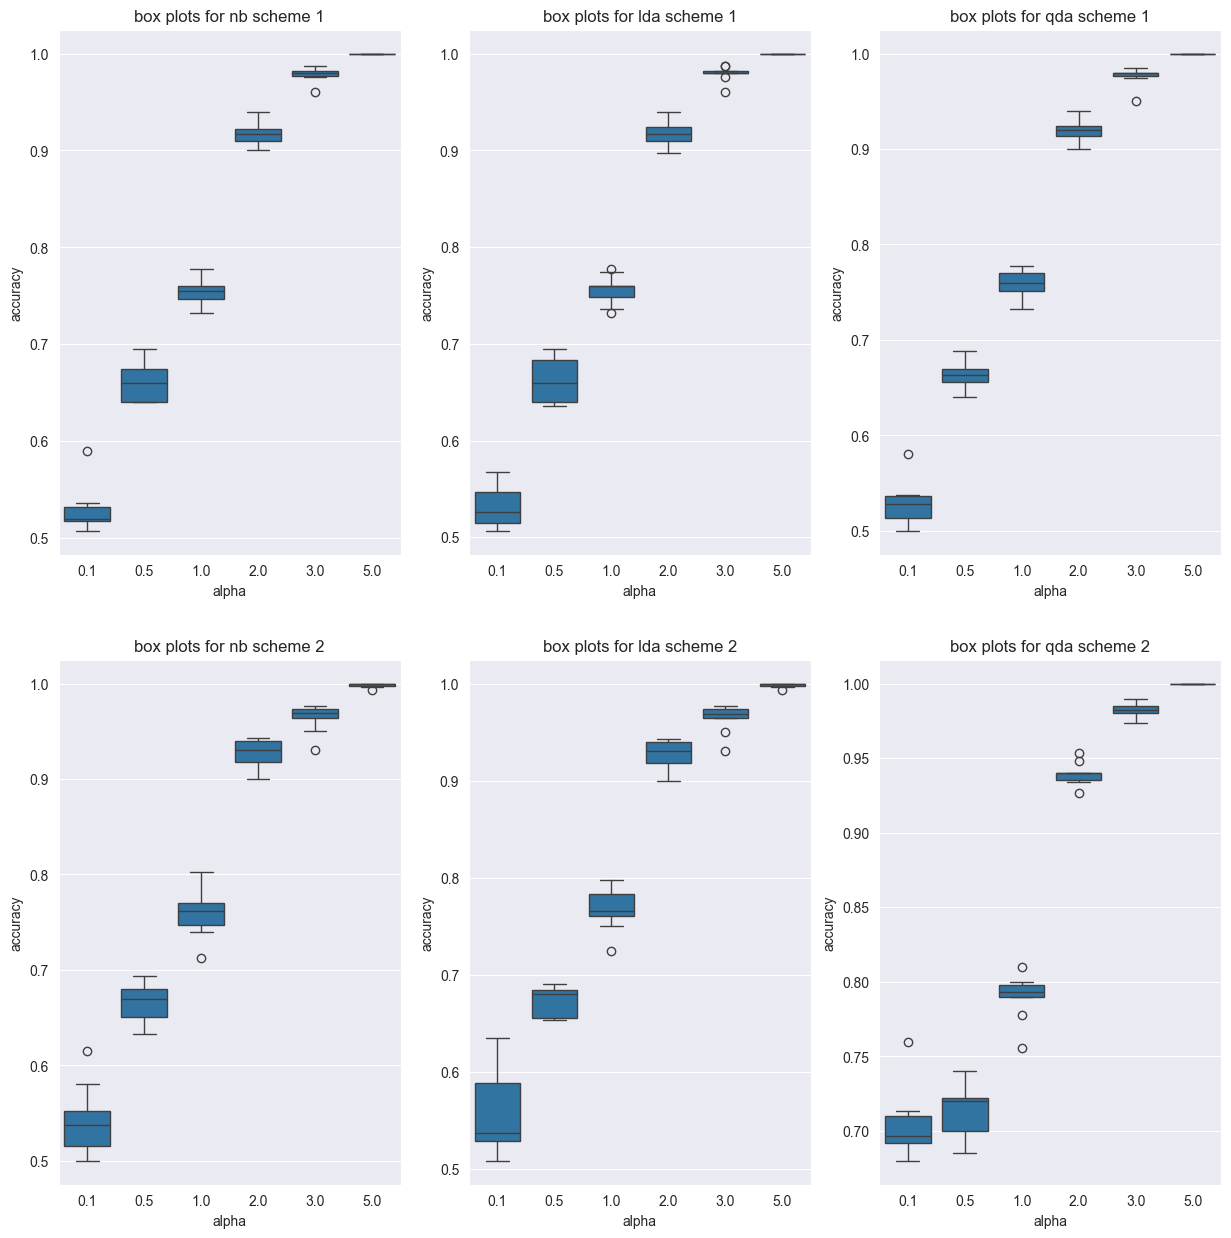

In [12]:
comparison_one()

In [13]:
def comparison_two():
    alpha=2
    splits=[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
    rho=[0,0.1,0.3,0.5,0.7]
    fig,axes=plt.subplots(2,3,figsize=(15,15))
    nb_df=pd.DataFrame(columns=['rho','accuracy'])
    lda_df=pd.DataFrame(columns=['rho','accuracy'])
    qda_df=pd.DataFrame(columns=['rho','accuracy'])
    nb_df2=pd.DataFrame(columns=['rho','accuracy'])
    lda_df2=pd.DataFrame(columns=['rho','accuracy'])
    qda_df2=pd.DataFrame(columns=['rho','accuracy'])
    for r in rho:
        X,y=prepare_data_scheme_one(alpha,1000)
        X_2,y_2=prepare_data_scheme_two(alpha,r,1000)
        for split in splits:
            X_train, y_train, X_test, y_test=split_train_test(X,y,split)
            X_2_train, y_2_train, X_2_test, y_2_test=split_train_test(X_2,y_2,split)
            nb=NB()
            nb2=NB()
            
            nb.fit(X_train,y_train)
            nb2.fit(X_2_train,y_2_train)
            
            lda=LDA()
            lda2=LDA()
            
            lda.fit(X_train,y_train)
            lda2.fit(X_2_train,y_2_train)
            
            qda=QDA()
            qda2=QDA()
            
            qda.fit(X_train,y_train)
            qda2.fit(X_2_train,y_2_train)
            
            nb_df.loc[nb_df.shape[0]]={'rho':r,'accuracy':np.abs((nb.predict(X_test)==y_test)).mean()}
            lda_df.loc[lda_df.shape[0]]={'rho':r,'accuracy':np.abs((lda.predict(X_test)==y_test)).mean()}
            qda_df.loc[qda_df.shape[0]]={'rho':r,'accuracy':np.abs((qda.predict(X_test)==y_test)).mean()}
        
            nb_df2.loc[nb_df2.shape[0]]={'rho':r,'accuracy':np.abs((nb2.predict(X_2_test)==y_2_test)).mean()}
            lda_df2.loc[lda_df2.shape[0]]={'rho':r,'accuracy':np.abs((lda2.predict(X_2_test)==y_2_test)).mean()}
            qda_df2.loc[qda_df2.shape[0]]={'rho':r,'accuracy':np.abs((qda2.predict(X_2_test)==y_2_test)).mean()}
    sns.boxplot(x='rho',y='accuracy',data=nb_df,ax=axes[0,0])
    axes[0,0].title.set_text("box plots for nb scheme 1")
    sns.boxplot(x='rho',y='accuracy',data=lda_df,ax=axes[0,1])
    axes[0,1].title.set_text("box plots for lda scheme 1")
    sns.boxplot(x='rho',y='accuracy',data=qda_df,ax=axes[0,2])
    axes[0,2].title.set_text("box plots for qda scheme 1")
    sns.boxplot(x='rho',y='accuracy',data=nb_df2,ax=axes[1,0])
    axes[1,0].title.set_text("box plots for nb scheme 2")
    sns.boxplot(x='rho',y='accuracy',data=lda_df2,ax=axes[1,1])
    axes[1,1].title.set_text("box plots for lda scheme 2")
    sns.boxplot(x='rho',y='accuracy',data=qda_df2,ax=axes[1,2])
    axes[1,2].title.set_text("box plots for qda scheme 2")

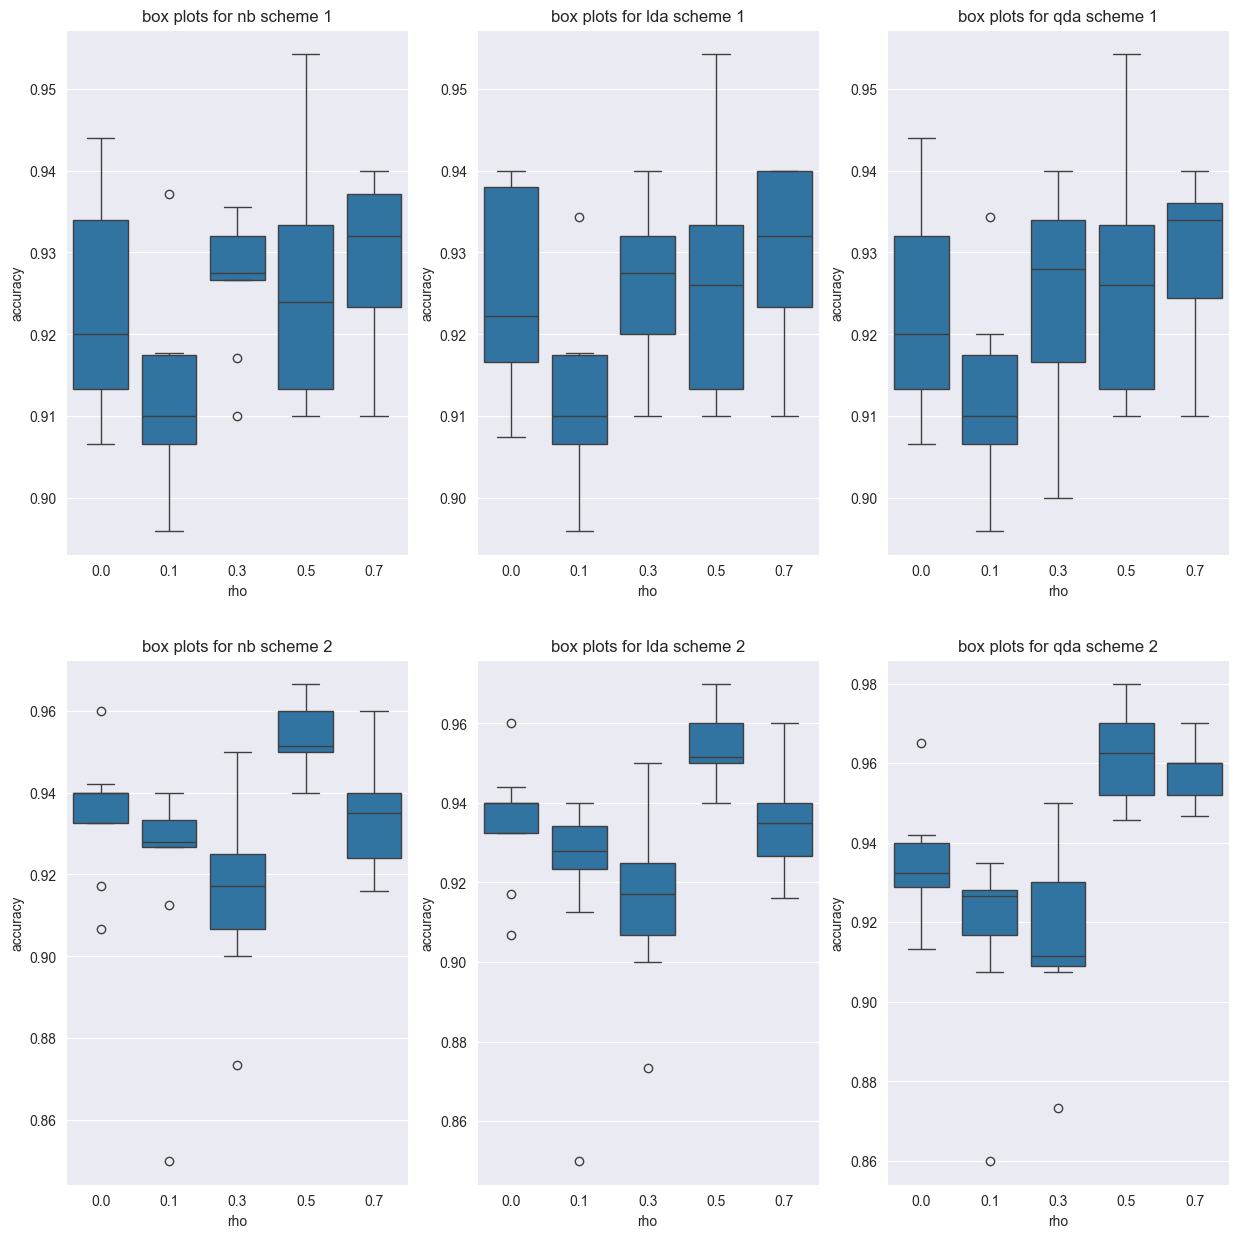

In [14]:
comparison_two()

In [15]:
def visualization():
    X,y=prepare_data_scheme_two(2,0.5,1000)
    x0,x1=binary_split_by_class(X,y)
    
    lda=LDA()
    lda.fit(X,y)
    qda=QDA()
    qda.fit(X,y)
    means, W, priors=lda.get_params()
    mu0=means[0].reshape((2,1))
    mu1=means[1].reshape((2,1))
    W_inv=np.linalg.inv(W)
    M=(mu0-mu1).T@W_inv
    def rev_x(x):
        return (M[0,0]*x-0.5*(mu0-mu1).T@W_inv@(mu0+mu1) +np.log(priors[0]/priors[1]))/(-M[0,1])
    mins=X.min(axis=0)
    maxs=X.max(axis=0)
    xscan=np.linspace(mins[0],maxs[0],100)
    yl=np.array([rev_x(xv) for xv in xscan] ).reshape(xscan.shape)
    plt.plot(xscan,yl, color="cyan")
    yscan=np.linspace(mins[1],maxs[1],100)
    onesx=[]
    onesy=[]
    zerosx=[]
    zerosy=[]
    for xs in xscan:
        for ys in yscan:
            dec=qda.predict(np.array([xs,ys]).reshape(1,2))
            if dec==1:
                onesx.append(xs)
                onesy.append(ys)
            else:
                zerosx.append(xs)
                zerosy.append(ys)
    plt.scatter(onesx,onesy,color='green',alpha=0.3)
    plt.scatter(zerosx,zerosy,color='yellow',alpha=0.3)
    plt.scatter(x0[:,0],x0[:,1],color='red')
    plt.scatter(x1[:,0],x1[:,1],color='blue')
    plt.show()

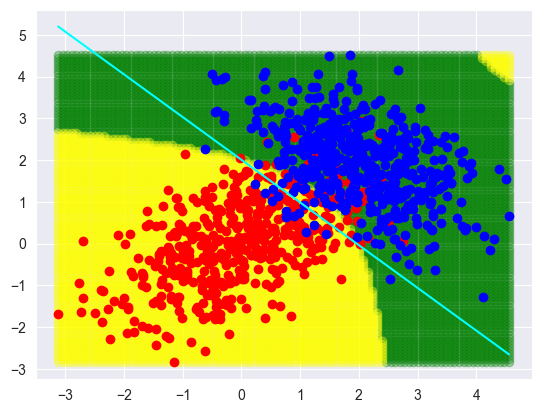

In [29]:
visualization()

# DataSets:

- delta_elevators (https://www.openml.org/data/download/53353/delta_elevators.arff) dataset1
- california (https://api.openml.org/data/download/22111914/dataset) dataset2
- blood-transfusion-service-center (https://www.openml.org/data/download/1586225/php0iVrYT) dataset3


In [17]:
import scipy.io.arff as arff

In [18]:
def load_data_from_arff(path,classInd,limit=1000):
    data=arff.loadarff(path)
    df=pd.DataFrame(data[0])
    df=df.iloc[np.random.permutation(df.shape[0])]
    return df.iloc[0:limit,0:df.shape[1]-1],df.iloc[0:limit,df.shape[1]-1].apply(lambda x: 1 if x==classInd else 0)
    

In [19]:
X,y=load_data_from_arff("dataset2.arff",bytes('1','utf-8'))

In [32]:
def real_data_scenario(limit=1000):
    datasets=[("dataset1.arff",bytes('P','utf-8')),("dataset2.arff",bytes('1','utf-8')),("dataset3.arff",bytes('2','utf-8'))]
    
    idx=0
    fig,axes=plt.subplots(1,3,figsize=(15,10))
    for dataset in datasets:
        X,y=load_data_from_arff(dataset[0],dataset[1],limit)
        
        df=pd.DataFrame(columns=['accuracy','model'])
        for split in range(7):
            X_train, y_train, X_test, y_test=split_train_test(X.to_numpy(),y.to_numpy(),0.7)
            
            nb=NB()
            nb.fit(X_train,y_train)
            lda=LDA()
            lda.fit(X_train,y_train)
            qda=QDA()
            qda.fit(X_train,y_train)
            df.loc[df.shape[0]]={'model':"nb",'accuracy':np.abs((nb.predict(X_test)==y_test)).mean()}
            df.loc[df.shape[0]]={'model':"lda",'accuracy':np.abs((lda.predict(X_test)==y_test)).mean()}
            df.loc[df.shape[0]]={'model':"qda",'accuracy':np.abs((qda.predict(X_test)==y_test)).mean()}
        sns.boxplot(x='model',y='accuracy',data=df,ax=axes[idx])
        axes[idx].title.set_text(f"box plots for dataset {idx+1}")
        idx+=1
    

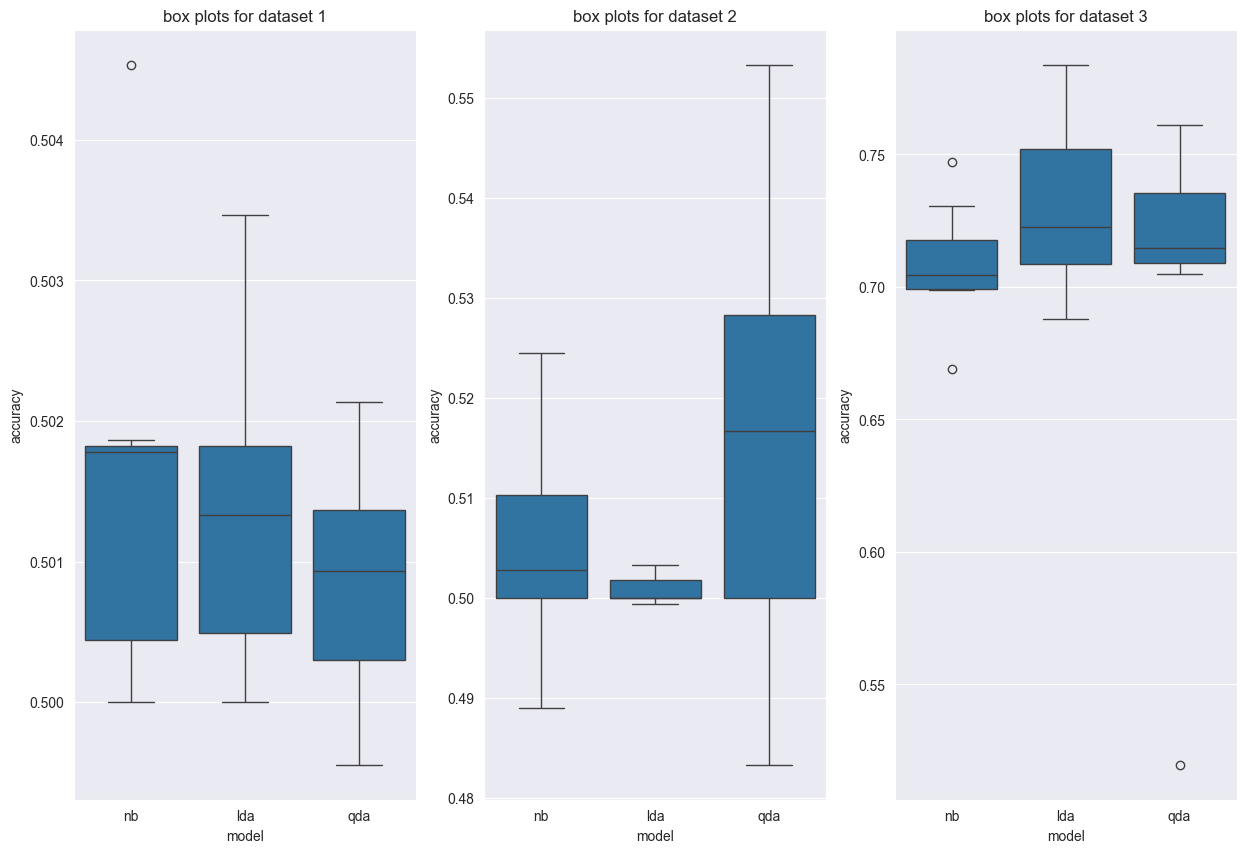

In [37]:
real_data_scenario(1000)